In [12]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm 

In [13]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [27]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Tue Jan 10 21:38:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/

In [28]:
#alternate sentiment model 
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
model = model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [29]:
def predict_sentiment(text):  
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    score = 0
    for i in range(len(scores)):
        score += (i-1)*scores[i]
    return score

In [30]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Full/modifiedgenerationfull.csv')

In [31]:
#quickly creating a sentiment dict and embedding dict 
sentiment_dict = {}
for response, group in tqdm(generations.groupby("response")):
  sentiment_dict[response] = predict_sentiment(response)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [01:24<00:00, 125.10it/s]


In [32]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

In [37]:
model.encode("hi")

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [33]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [35]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(sentiment_dict[response])
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

  0%|                                                                                                                                                                               | 0/197 [00:00<?, ?it/s]


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for id in exploration:
  # if .7 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

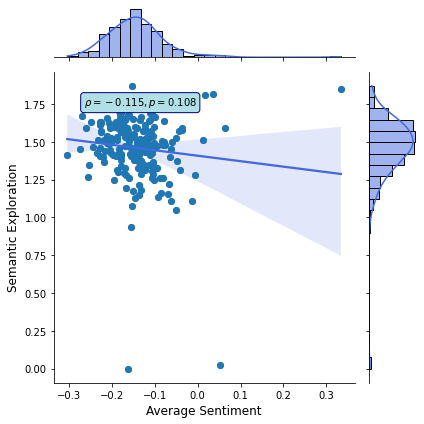

In [ ]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

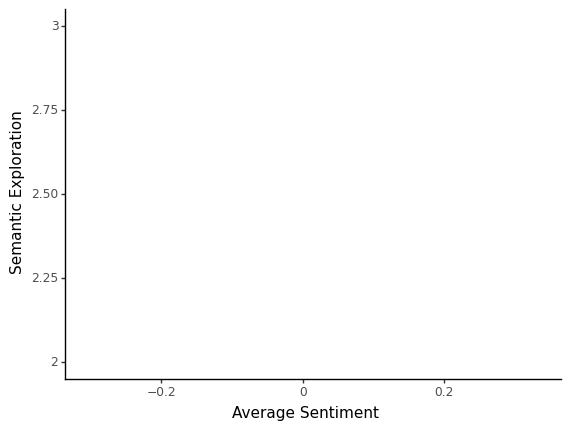

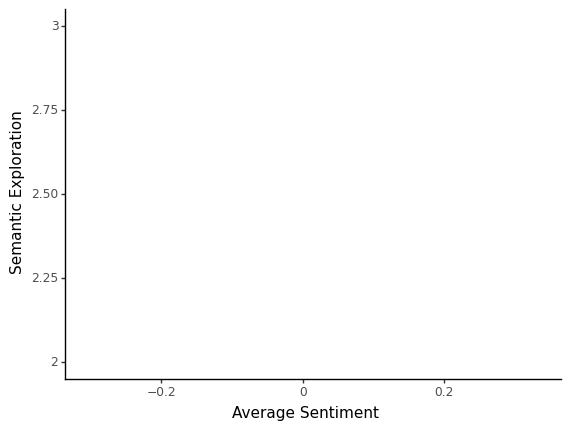

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [ ]:
generations

Unnamed: 0 vignette_name  generation_number  generation_time  \
0               0         Erica                  1                0   
1               1         Erica                  2                0   
2               2         Erica                  3                0   
3               3         Erica                  4                0   
4               4         Erica                  5                0   
...           ...           ...                ...              ...   
12180       12180       Cameron                  2                0   
12181       12181       Cameron                  3                0   
12182       12182       Cameron                  4                0   
12183       12183       Cameron                  5                0   
12184       12184       Cameron                  6                0   

                                                response  reflection_score  \
0                               break one of the windows                 0   
1                                        call the police                 0   
2                                    alert mall security                 0   
3                                ask a stranger for help                 0   
4                                               call 911                 0   
...                                                  ...               ...   
12180                                       Tell her no.                 0   
12181  Take her as far as you are going and drop her off                 0   
12182                                         Call a cab                 0   
12183                    Ask someone else at the station                 0   
12184  Tell her you are going in the opposite direction.                 0   

                     id  
0      YX5fuO4VpL3Et7bB  
1      YX5fuO4VpL3Et7bB  
2      YX5fuO4VpL3Et7bB  
3      YX5fuO4VpL3Et7bB  
4      YX5fuO4VpL3Et7bB  
...                 ...  
12180  1SczUqX7VCwAfGkB  
12181  1SczUqX7VCwAfGkB  
12182  1SczUqX7VCwAfGkB  
12183  1SczUqX7VCwAfGkB  
12184  1SczUqX7VCwAfGkB  

[12185 rows x 7 columns]

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    if len(embeddings) > 0:
      e = 0
      for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
          e += dist(embeddings[i], embeddings[j])
      exploration[pnum].append(e/len(embeddings))
      exp.append(e/len(embeddings))
      nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

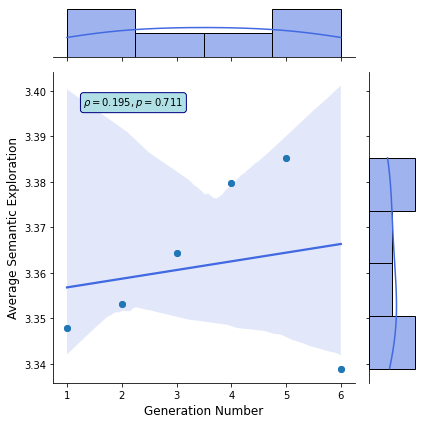

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

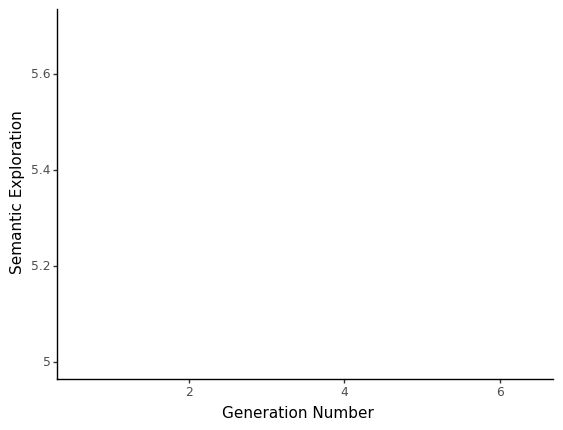

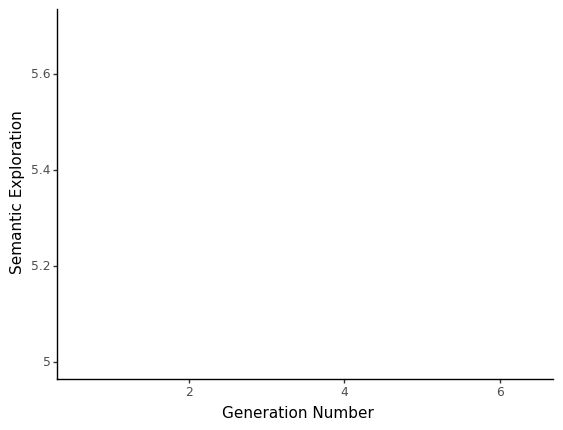

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    if len(embeddings) > 0:
      vectordic.get(pnum).append(embeddings)


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

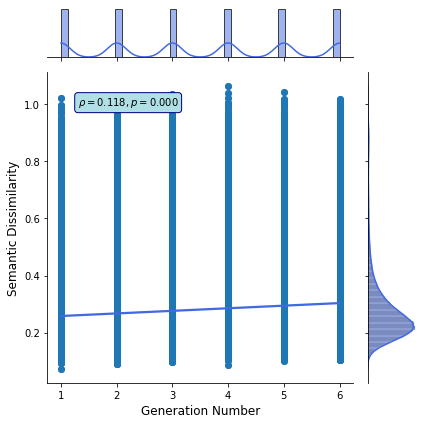

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

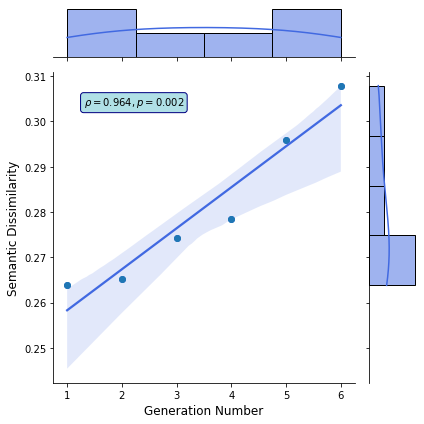

In [ ]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

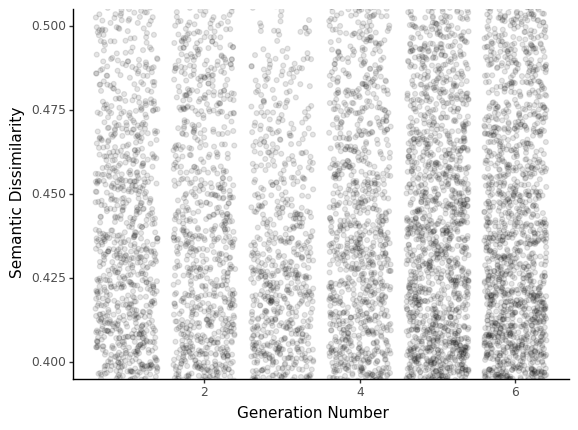

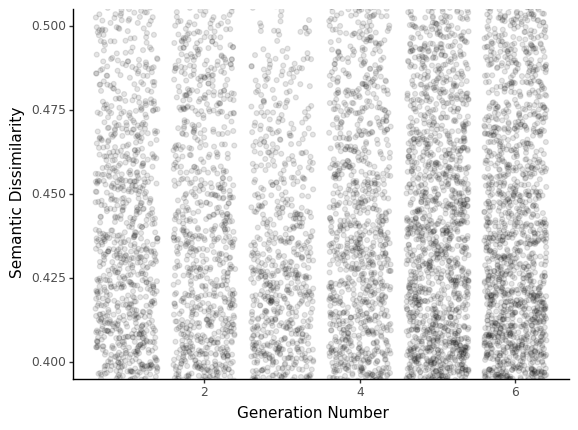

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**

In [ ]:
#average goodness rating per possibility 
scores = [[] for i in range(6)]
nums = [i for i in range(6)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


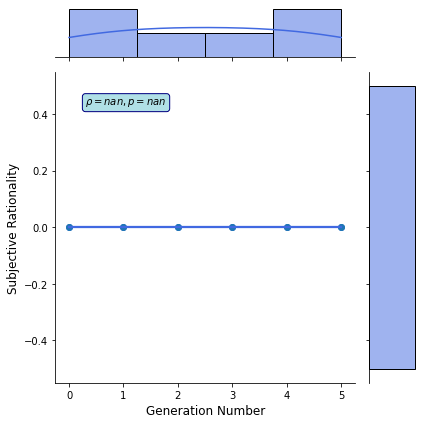

In [ ]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


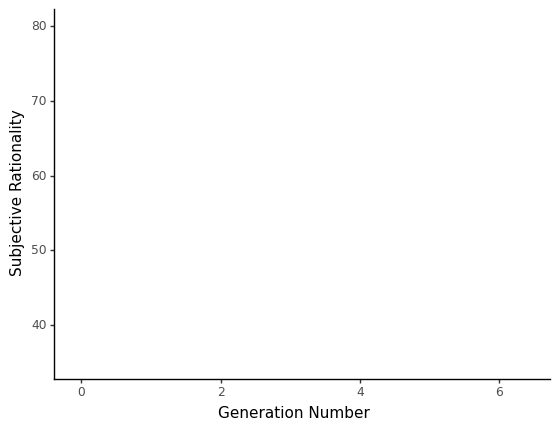

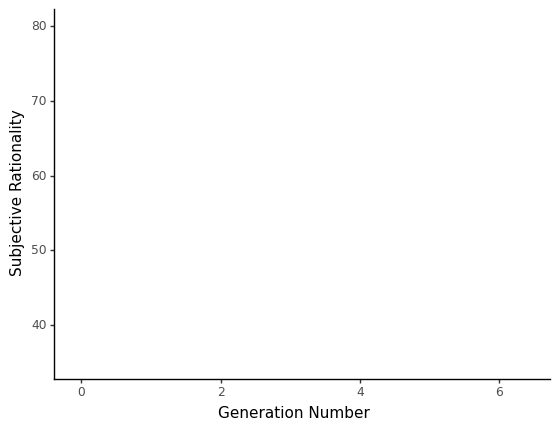

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [ ]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in generations.groupby('id'):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = sentiment_dict[generation]
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

In [ ]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

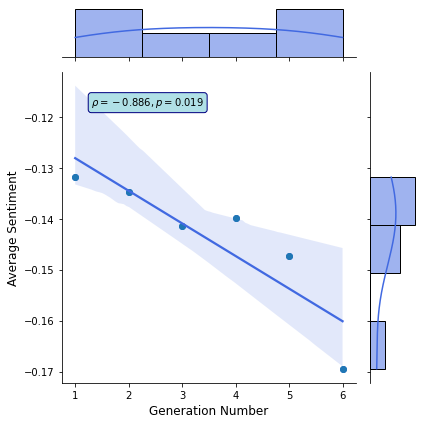

In [ ]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


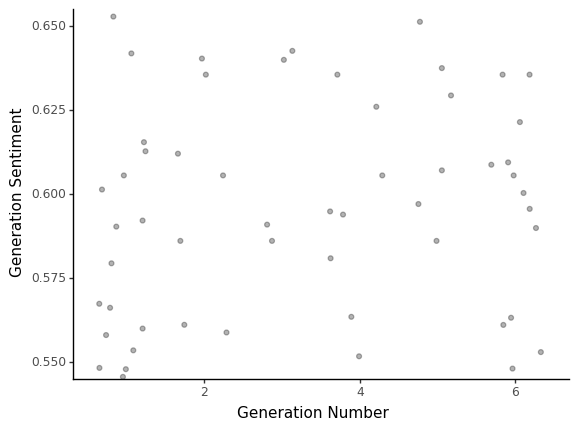

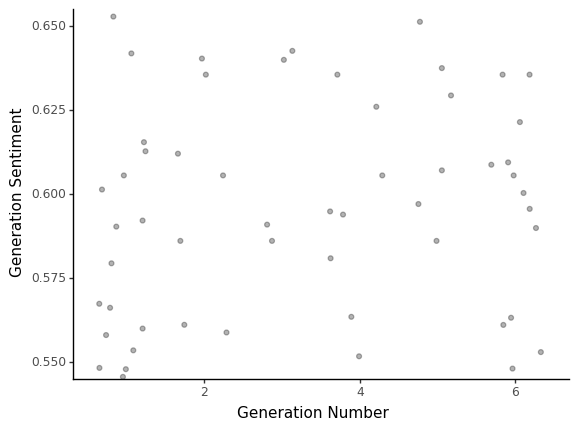

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [ ]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [ ]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [ ]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [ ]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.7767954178691747, 2: 2.755848183513439, 3: 2.719223207388812, 4: 2.7368169596840737, 5: 2.718266124602115, 6: 2.7033914427220993}


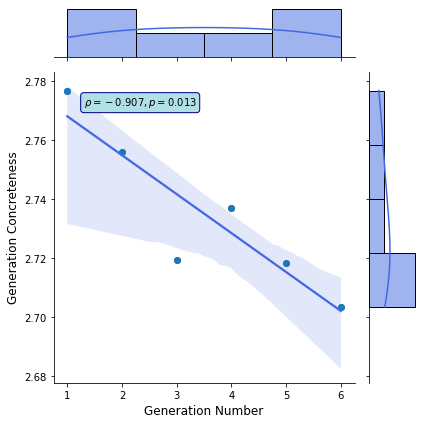

In [ ]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

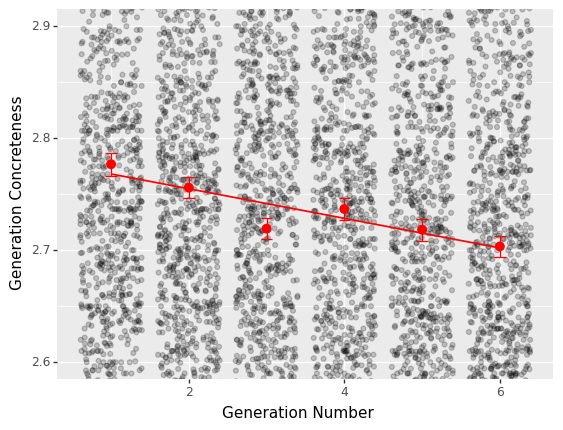

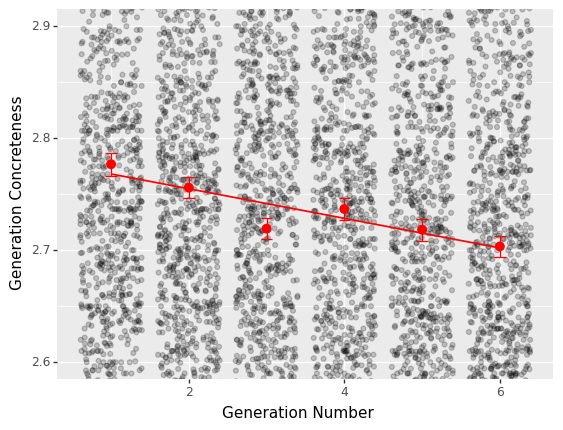

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

10385

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


  1%|          | 1/100 [00:04<06:42,  4.06s/it]

0


  2%|▏         | 2/100 [00:06<04:52,  2.99s/it]

1


  3%|▎         | 3/100 [00:08<04:15,  2.63s/it]

2


  4%|▍         | 4/100 [00:10<03:57,  2.47s/it]

3


  5%|▌         | 5/100 [00:12<03:46,  2.39s/it]

4


  6%|▌         | 6/100 [00:15<03:38,  2.33s/it]

5


  7%|▋         | 7/100 [00:17<03:34,  2.30s/it]

6


  8%|▊         | 8/100 [00:19<03:30,  2.29s/it]

7


  9%|▉         | 9/100 [00:21<03:25,  2.26s/it]

8


 10%|█         | 10/100 [00:24<03:22,  2.25s/it]

9


 11%|█         | 11/100 [00:26<03:18,  2.23s/it]

10


 12%|█▏        | 12/100 [00:28<03:17,  2.24s/it]

11


 13%|█▎        | 13/100 [00:30<03:14,  2.23s/it]

12


 14%|█▍        | 14/100 [00:32<03:11,  2.23s/it]

13


 15%|█▌        | 15/100 [00:35<03:08,  2.22s/it]

14


 16%|█▌        | 16/100 [00:37<03:06,  2.22s/it]

15


 17%|█▋        | 17/100 [00:39<03:03,  2.22s/it]

16


 18%|█▊        | 18/100 [00:41<03:01,  2.21s/it]

17


 19%|█▉        | 19/100 [00:44<02:58,  2.21s/it]

18


 20%|██        | 20/100 [00:46<03:13,  2.41s/it]

19


 21%|██        | 21/100 [00:49<03:05,  2.35s/it]

20


 22%|██▏       | 22/100 [00:51<02:59,  2.31s/it]

21


 23%|██▎       | 23/100 [00:53<02:56,  2.30s/it]

22


 24%|██▍       | 24/100 [00:55<02:53,  2.28s/it]

23


 25%|██▌       | 25/100 [00:58<02:49,  2.26s/it]

24


 26%|██▌       | 26/100 [01:00<02:46,  2.25s/it]

25


 27%|██▋       | 27/100 [01:02<02:42,  2.23s/it]

26


 28%|██▊       | 28/100 [01:04<02:40,  2.23s/it]

27


 29%|██▉       | 29/100 [01:06<02:37,  2.22s/it]

28


 30%|███       | 30/100 [01:09<02:54,  2.49s/it]

29


 31%|███       | 31/100 [01:12<02:55,  2.54s/it]

30


 32%|███▏      | 32/100 [01:14<02:46,  2.45s/it]

31


 33%|███▎      | 33/100 [01:17<02:39,  2.37s/it]

32


 34%|███▍      | 34/100 [01:19<02:33,  2.32s/it]

33


 35%|███▌      | 35/100 [01:21<02:29,  2.31s/it]

34


 36%|███▌      | 36/100 [01:23<02:25,  2.28s/it]

35


 37%|███▋      | 37/100 [01:26<02:22,  2.26s/it]

36


 38%|███▊      | 38/100 [01:28<02:32,  2.46s/it]

37


 39%|███▉      | 39/100 [01:31<02:26,  2.39s/it]

38


 40%|████      | 40/100 [01:33<02:21,  2.36s/it]

39


 41%|████      | 41/100 [01:35<02:17,  2.33s/it]

40


 42%|████▏     | 42/100 [01:37<02:13,  2.30s/it]

41


 43%|████▎     | 43/100 [01:40<02:09,  2.28s/it]

42


 44%|████▍     | 44/100 [01:42<02:06,  2.26s/it]

43


 45%|████▌     | 45/100 [01:44<02:03,  2.25s/it]

44


 46%|████▌     | 46/100 [01:46<02:01,  2.25s/it]

45


 47%|████▋     | 47/100 [01:49<01:58,  2.23s/it]

46


 48%|████▊     | 48/100 [01:51<01:55,  2.23s/it]

47


 49%|████▉     | 49/100 [01:53<01:53,  2.22s/it]

48


 50%|█████     | 50/100 [01:55<01:50,  2.22s/it]

49


 51%|█████     | 51/100 [01:57<01:48,  2.22s/it]

50


 52%|█████▏    | 52/100 [02:00<01:46,  2.23s/it]

51


 53%|█████▎    | 53/100 [02:02<01:44,  2.22s/it]

52


 54%|█████▍    | 54/100 [02:04<01:42,  2.23s/it]

53


 55%|█████▌    | 55/100 [02:06<01:40,  2.23s/it]

54


 56%|█████▌    | 56/100 [02:09<01:37,  2.23s/it]

55


 57%|█████▋    | 57/100 [02:11<01:35,  2.22s/it]

56


 58%|█████▊    | 58/100 [02:13<01:33,  2.22s/it]

57


 59%|█████▉    | 59/100 [02:15<01:30,  2.22s/it]

58


 60%|██████    | 60/100 [02:17<01:28,  2.22s/it]

59


 61%|██████    | 61/100 [02:20<01:26,  2.21s/it]

60


 62%|██████▏   | 62/100 [02:22<01:31,  2.40s/it]

61


 63%|██████▎   | 63/100 [02:25<01:27,  2.37s/it]

62


 64%|██████▍   | 64/100 [02:27<01:24,  2.34s/it]

63


 65%|██████▌   | 65/100 [02:29<01:20,  2.30s/it]

64


 66%|██████▌   | 66/100 [02:31<01:17,  2.29s/it]

65


 67%|██████▋   | 67/100 [02:34<01:14,  2.27s/it]

66


 68%|██████▊   | 68/100 [02:36<01:11,  2.25s/it]

67


 69%|██████▉   | 69/100 [02:38<01:09,  2.24s/it]

68


 70%|███████   | 70/100 [02:40<01:06,  2.23s/it]

69


 71%|███████   | 71/100 [02:43<01:04,  2.23s/it]

70


 72%|███████▏  | 72/100 [02:45<01:02,  2.22s/it]

71


 73%|███████▎  | 73/100 [02:47<01:00,  2.24s/it]

72


 74%|███████▍  | 74/100 [02:49<00:57,  2.23s/it]

73


 75%|███████▌  | 75/100 [02:51<00:55,  2.23s/it]

74


 76%|███████▌  | 76/100 [02:54<00:53,  2.23s/it]

75


 77%|███████▋  | 77/100 [02:56<00:51,  2.23s/it]

76


 78%|███████▊  | 78/100 [02:58<00:49,  2.24s/it]

77


 79%|███████▉  | 79/100 [03:00<00:47,  2.24s/it]

78


 80%|████████  | 80/100 [03:03<00:44,  2.24s/it]

79


 81%|████████  | 81/100 [03:05<00:42,  2.23s/it]

80


 82%|████████▏ | 82/100 [03:07<00:40,  2.23s/it]

81


 83%|████████▎ | 83/100 [03:09<00:37,  2.22s/it]

82


 84%|████████▍ | 84/100 [03:11<00:35,  2.21s/it]

83


 85%|████████▌ | 85/100 [03:14<00:33,  2.21s/it]

84


 86%|████████▌ | 86/100 [03:16<00:30,  2.21s/it]

85


 87%|████████▋ | 87/100 [03:18<00:28,  2.21s/it]

86


 88%|████████▊ | 88/100 [03:20<00:26,  2.21s/it]

87


 89%|████████▉ | 89/100 [03:23<00:24,  2.21s/it]

88


 90%|█████████ | 90/100 [03:25<00:21,  2.20s/it]

89


 91%|█████████ | 91/100 [03:27<00:19,  2.22s/it]

90


 92%|█████████▏| 92/100 [03:29<00:17,  2.22s/it]

91


 93%|█████████▎| 93/100 [03:31<00:15,  2.23s/it]

92


 94%|█████████▍| 94/100 [03:34<00:13,  2.22s/it]

93


 95%|█████████▌| 95/100 [03:36<00:11,  2.21s/it]

94


 96%|█████████▌| 96/100 [03:38<00:08,  2.21s/it]

95


 97%|█████████▋| 97/100 [03:40<00:06,  2.21s/it]

96


 98%|█████████▊| 98/100 [03:42<00:04,  2.21s/it]

97


 99%|█████████▉| 99/100 [03:45<00:02,  2.21s/it]

98


100%|██████████| 100/100 [03:47<00:00,  2.27s/it]

99


{0: [0.8785929903388023,
  0.8984178304672241,
  0.8453293442726135,
  0.9795213732868433,
  0.8997306227684021,
  0.9010542035102844,
  0.9217608645558357,
  0.8616750985383987,
  1.0068414639681578,
  0.8525814414024353,
  0.9337845370173454,
  0.8825598359107971,
  0.6935602724552155,
  0.9006440490484238,
  1.01435970608145,
  0.9091702848672867,
  0.9468085654079914,
  1.013826671987772,
  1.0172769948840141,
  1.0123236831277609,
  0.992779235355556,
  0.9887319207191467,
  0.8945333883166313,
  0.7798929810523987,
  0.8928428292274475,
  0.8558860719203949,
  0.8581956475973129,
  0.9030194655060768,
  0.8910012170672417,
  1.0386218130588531,
  0.9177484586834908,
  0.6856911480426788,
  0.7912408262491226,
  0.8144618719816208,
  0.9463716223835945,
  0.82408607006073,
  0.8303490877151489,
  0.9787995144724846,
  0.8476301729679108,
  0.9383724704384804,
  0.9501078128814697,
  0.9861640520393848,
  0.9203106090426445,
  0.9980798400938511,
  0.788415789604187,
  0.7516051381

In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

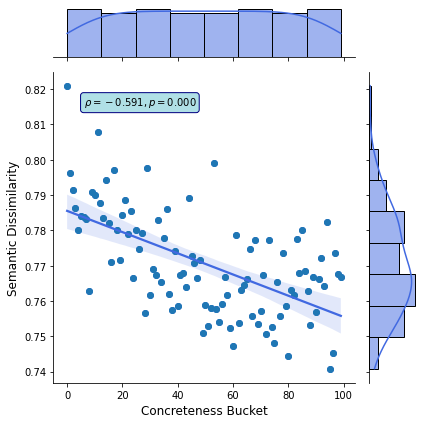

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

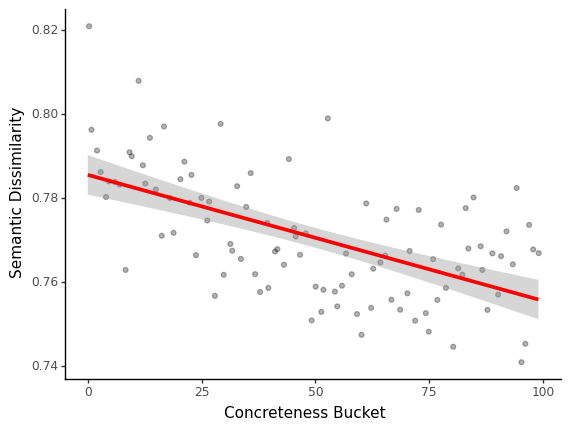

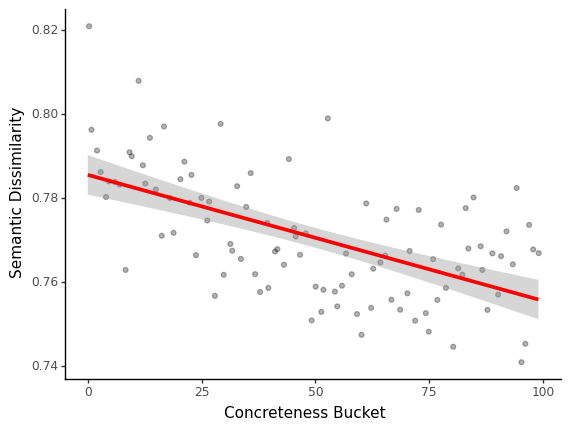

In [ ]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [ ]:
# semantic exploration 
exploration = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#determine avg concreteness 
id_concreteness = {}
for id, group in generations.groupby("id"):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

In [ ]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [ ]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

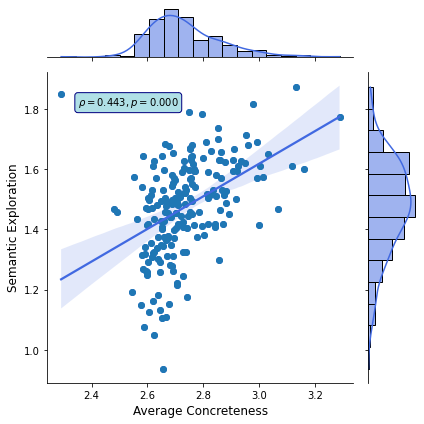

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

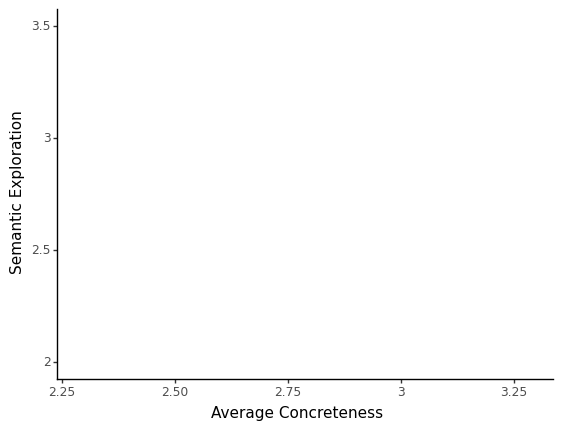

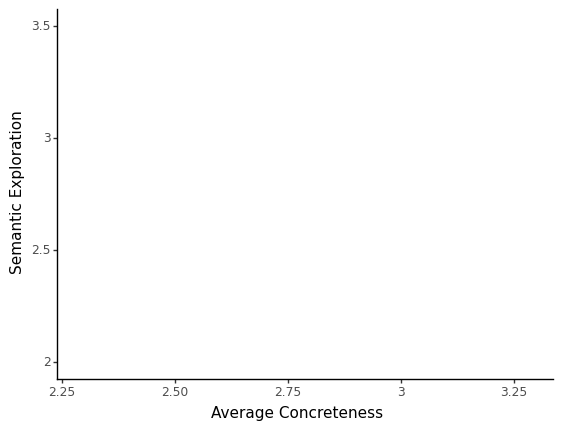

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [ ]:
concreteness = []
subjective = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


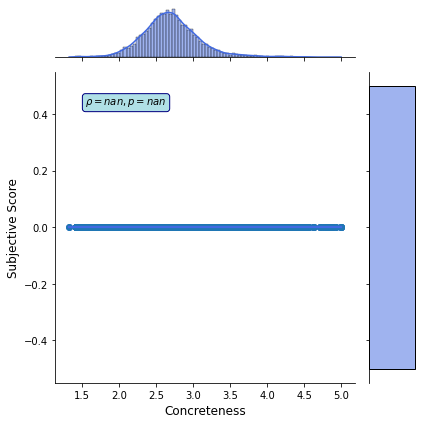

In [ ]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [ ]:
concreteness = []
sentiment = []
for response, group in generations.groupby("response"):
  words = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(words.split(" "))
  for word in words.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(sentiment_dict[response])


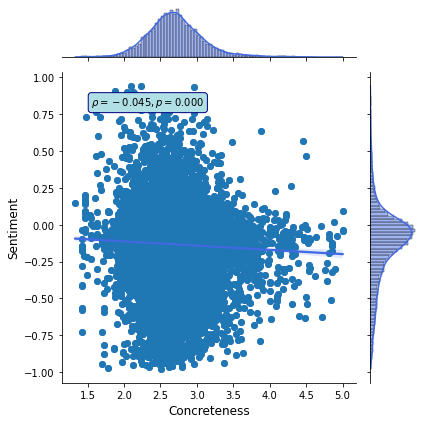

In [ ]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()